In [ ]:
# CAM_C101 Mini-Project 6.3: Customer Segmentation with Clustering
# Candidate: Kazi Md Hasanul Hoque
# Date: 28/09/2025

# ============================
# 1. Importing the required libraries and data set with the provided URL.

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import io
import requests

# Preprocessing & pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [47]:
# Load and Inspect the Dataset

url = 'https://github.com/FourthRevGitHub/CAM_DS_Public-Data-Sets/raw/main/Course%201/Week%206/CUSTOMERS_CLEAN.zip'
# Download the ZIP file
response = requests.get(url)

# Open the ZIP file
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    # List the file names in the ZIP
    zip_ref.printdir()
    
    # Extract the CSV file
    csv_filename = zip_ref.namelist()[0]  # Assumes the first file is the one you're interested in
    with zip_ref.open(csv_filename) as my_file:
        df = pd.read_csv(my_file)

# Display the first few rows of the DataFrame
print(df.head())

File Name                                             Modified             Size
CUSTOMERS_CLEAN.csv                            2025-03-20 12:20:58    190631280
   Quantity         City      Continent Postal_Code     State_Province  \
0         3     Leinster        Oceania        6437  Western Australia   
1         2      Berowra        Oceania        2081    New South Wales   
2         2      Berowra        Oceania        2081    New South Wales   
3         1  Northbridge        Oceania        2063    New South Wales   
4         1     Montréal  North America         NaN             Quebec   

  Order_Date Delivery_Date Total Revenue Unit Cost Discount OrderTypeLabel  \
0  01JAN2012     07JAN2012       $28.50     $9.10         .  Internet Sale   
1  01JAN2012     04JAN2012      $113.40    $56.90         .  Internet Sale   
2  01JAN2012     04JAN2012       $41.00    $18.50         .  Internet Sale   
3  01JAN2012     03JAN2012       $35.20    $29.60         .  Internet Sale   
4  01

In [ ]:
2. Cleaning, Duplicates, Conversion

In [49]:
# Remove duplicates
df = df.drop_duplicates()

# Remove $ and convert columns to numbers
for col in ['Total Revenue', 'Profit', 'Unit Cost']:
    df[col] = pd.to_numeric(
        df[col]
        .astype(str)
        .replace({'\$':'','\(':'-','\)':'', ',':''}, regex=True),
        errors='coerce'
    )

# Dates to datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Customer_BirthDate'] = pd.to_datetime(df['Customer_BirthDate'], errors='coerce')

print(df[['Total Revenue', 'Profit', 'Unit Cost']].dtypes)
print(df[['Order_Date', 'Customer_BirthDate']].dtypes)


Total Revenue    float64
Profit           float64
Unit Cost        float64
dtype: object
Order_Date            datetime64[ns]
Customer_BirthDate    datetime64[ns]
dtype: object


In [ ]:
3. Feature Engineering (Aggregation)

In [ ]:
# Reference for recency and age calculation (latest order date)
reference_date = df['Order_Date'].max()

# Aggregate to customer level with required features
customer_features = df.groupby('Customer ID').agg({
    'Order ID': 'count',                # Frequency (number of orders)
    'Order_Date': 'max',                # Most recent order for recency
    'Profit': 'sum',                    # CLV proxy
    'Unit Cost': 'mean',                # Avg unit cost per order
    'Customer_BirthDate': 'first'       # Customer birthdate (unique per cust)
}).rename(columns={
    'Order ID': 'Frequency',
    'Order_Date': 'Last_Order_Date',
    'Profit': 'CLV',
    'Unit Cost': 'Avg_Unit_Cost'
}).reset_index()

# Calculate Recency (days since last order)
customer_features['Recency'] = (reference_date - customer_features['Last_Order_Date']).dt.days

# Calculate Age (years)
customer_features['Customer_Age'] = ((reference_date - customer_features['Customer_BirthDate']).dt.days // 365)

# Retain relevant columns only
customer_features = customer_features[['Customer ID', 'Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Customer_Age']]

In [ ]:
4. EDA & Outlier Detection on 5 Features

          Frequency       Recency           CLV  Avg_Unit_Cost  Customer_Age
count  68300.000000  68300.000000  68300.000000   68300.000000  68300.000000
mean      13.933353    367.662167    120.926783      78.895675     43.134319
std       11.328807    414.511202    159.875970      38.005259     17.486209
min        1.000000      0.000000  -1153.150000       0.500000     19.000000
25%        6.000000     45.000000     26.800000      57.579792     28.000000
50%       11.000000    190.000000     83.890000      73.450000     43.000000
75%       19.000000    539.250000    175.900000      92.515260     58.000000
max      121.000000   1824.000000   2630.380000    1463.500000     74.000000


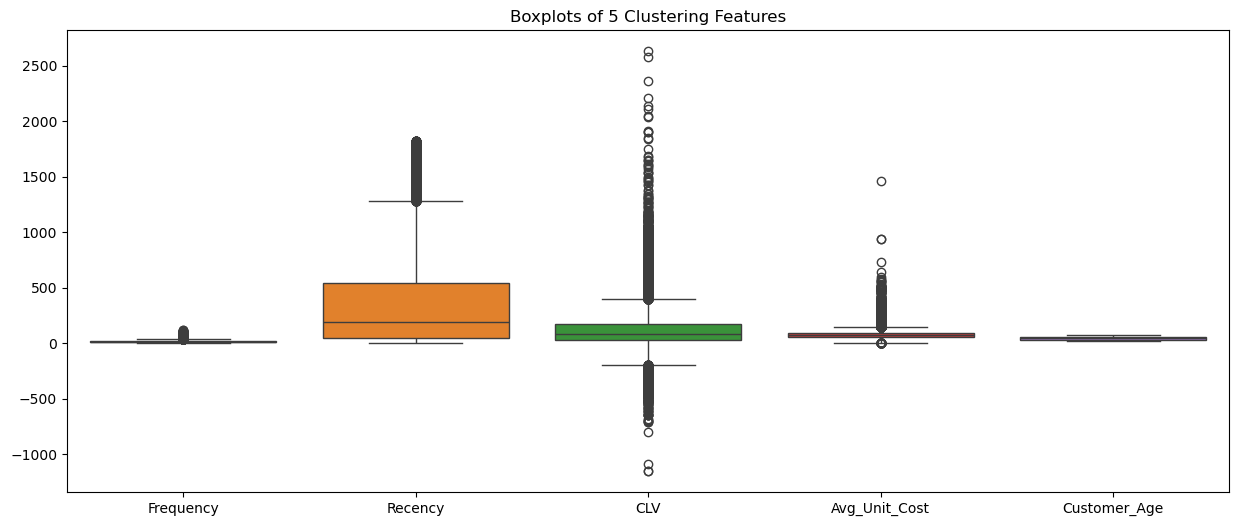

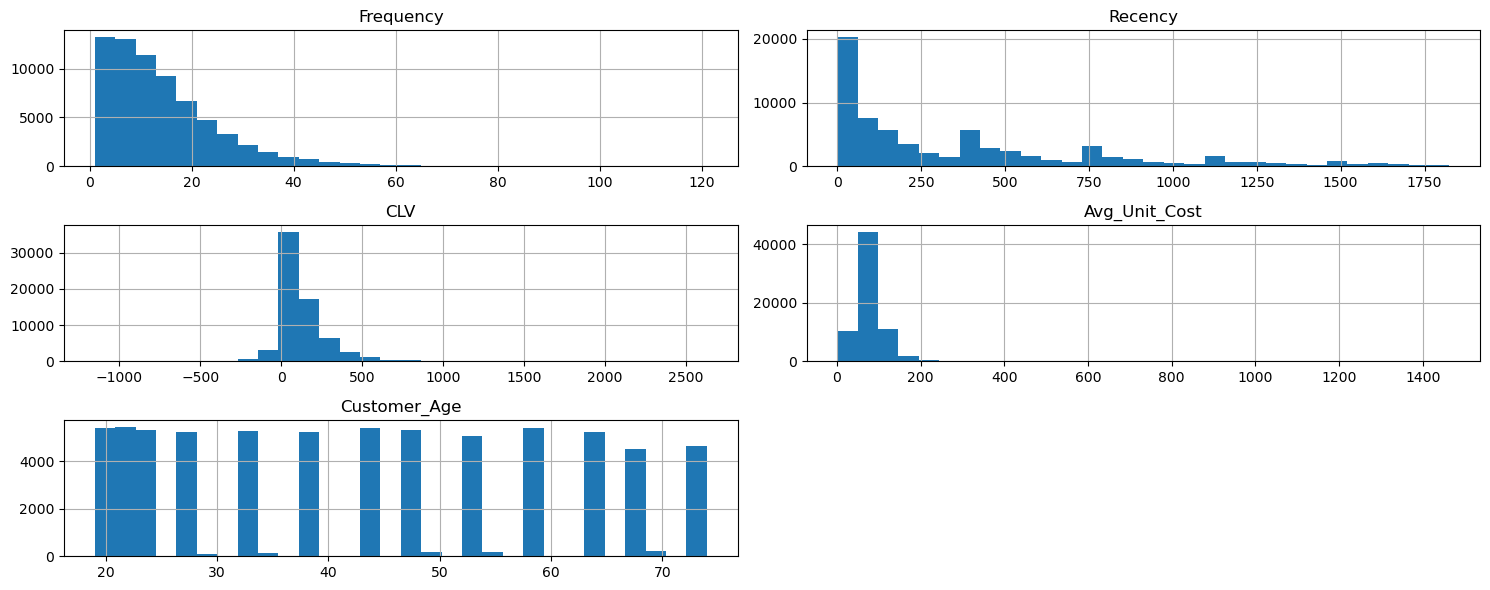

In [51]:
# EDA: summary/describe
print(customer_features[['Frequency','Recency','CLV','Avg_Unit_Cost','Customer_Age']].describe())

# Outlier visualisation
plt.figure(figsize=(15,6))
sns.boxplot(data=customer_features[['Frequency','Recency','CLV','Avg_Unit_Cost','Customer_Age']])
plt.title('Boxplots of 5 Clustering Features')
plt.show()

# Histograms
customer_features[['Frequency','Recency','CLV','Avg_Unit_Cost','Customer_Age']].hist(figsize=(15,6), bins=30)
plt.tight_layout()
plt.show()


In [ ]:
5. Scaling 

In [52]:
from sklearn.preprocessing import StandardScaler

X = customer_features[['Frequency','Recency','CLV','Avg_Unit_Cost','Customer_Age']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
6. Finding Optimal Number of Clusters (k)

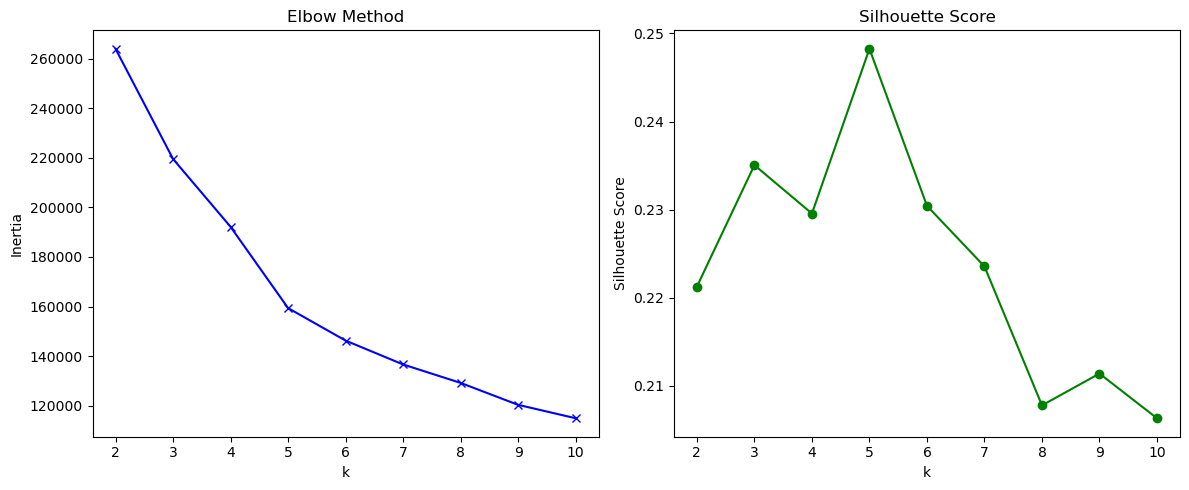

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list(k_range), inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(list(k_range), silhouette, 'go-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()

# Pick k based on above; here we'll use 4 as example:
optimal_k = 4


In [ ]:
7. K-means Clustering

In [58]:
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
customer_features['Cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
8. Cluster Visualization

In [ ]:
Boxplots by Cluster:

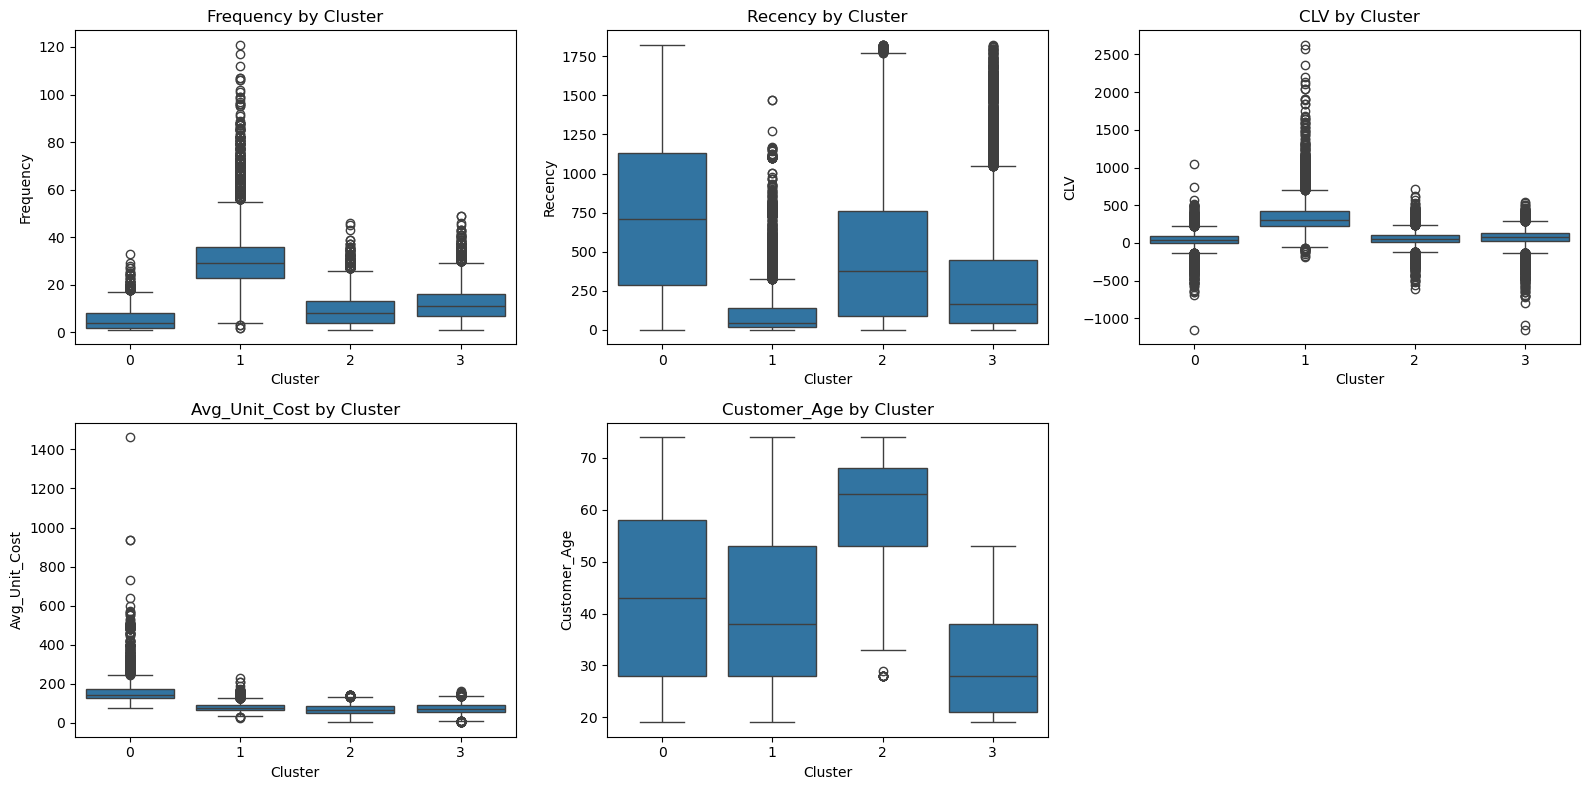

In [61]:
plt.figure(figsize=(16,8))
for i, feat in enumerate(['Frequency','Recency','CLV','Avg_Unit_Cost','Customer_Age']):
    plt.subplot(2,3,i+1)
    sns.boxplot(x='Cluster', y=feat, data=customer_features)
    plt.title(f'{feat} by Cluster')
plt.tight_layout()
plt.show()


In [ ]:
PCA and t-SNE (2D Visualisation):

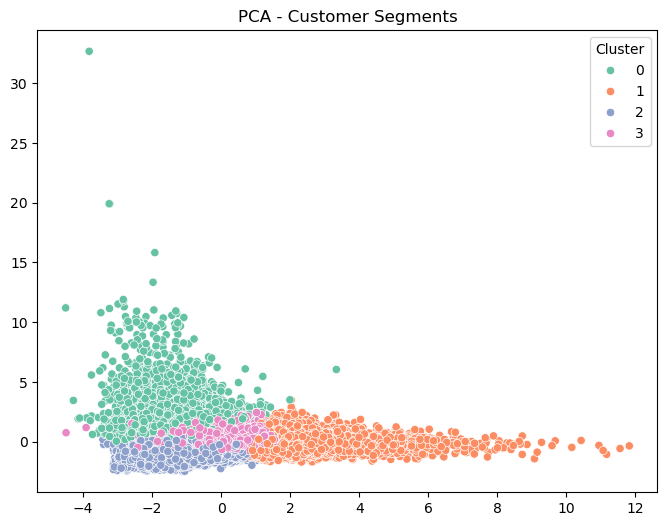

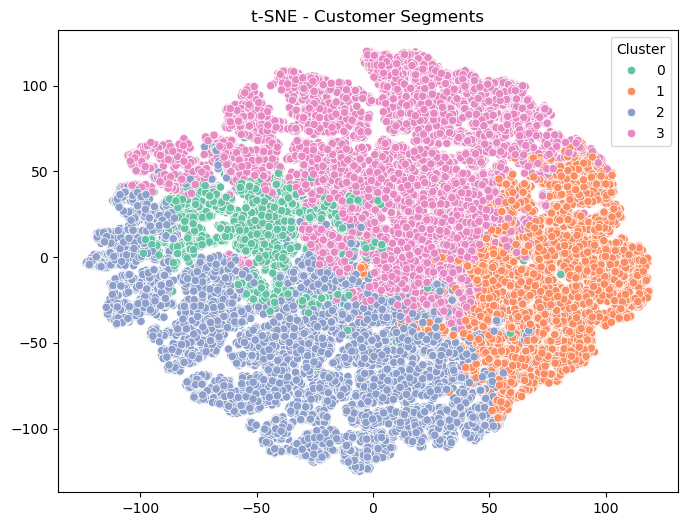

In [60]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_2d[:,0], y=pca_2d[:,1], hue=customer_features['Cluster'], palette='Set2')
plt.title('PCA - Customer Segments')
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=customer_features['Cluster'], palette='Set2')
plt.title('t-SNE - Customer Segments')
plt.show()


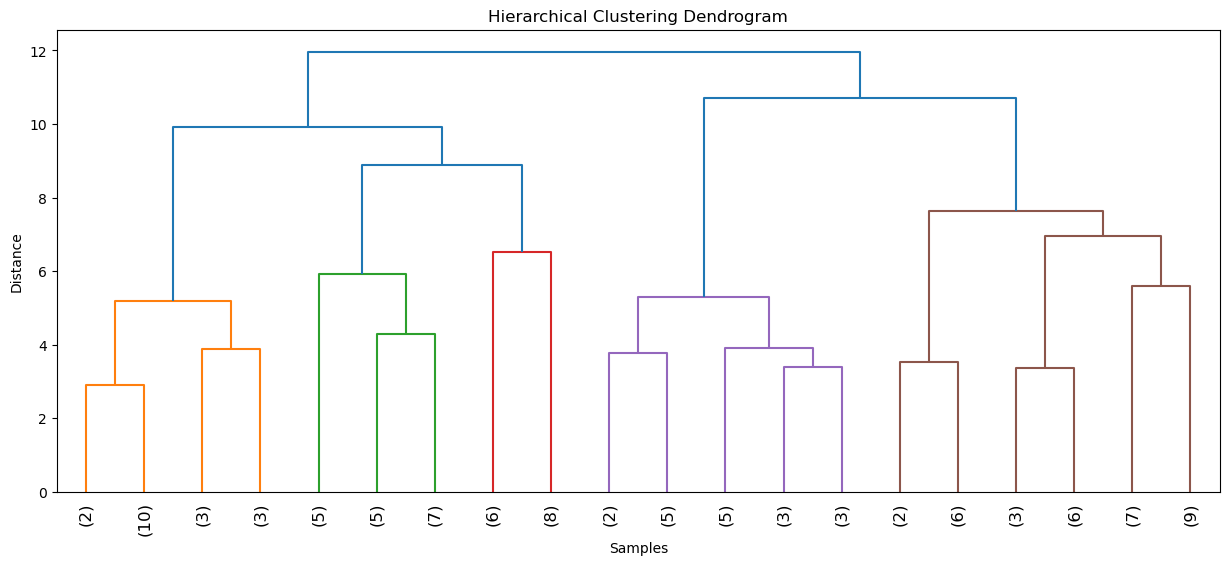

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Create some sample data - replace this with your actual data
# For example:
X = np.random.rand(100, 5)  # 100 samples with 5 features

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Now create the dendrogram
plt.figure(figsize=(15, 6))
Z = linkage(X_scaled, method='ward')
dendrogram(Z, truncate_mode='lastp', p=20, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()